# Imports

In [1]:
import os
import json
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import soundfile as sf
import librosa

In [2]:
# The path for all data sets.
DATA_PATH = "data"
# Spectrogram frequency sample rate.
N_FFT = 512
# Time scale for spectrogram.
TIME_SCALE = 3
# The intensity of the enhancement.
ENHANCE_FACTOR = 32

# Threshold for the detection.
POSITIVE_THRESHOLD = 0.7
NEGATIVE_THRESHOLD = 0.3

# Read Data Set and Preprocessing

## Read Data Set

- Store all the training data in DATA_PATH
- Use the same name for audio file and label file, for example:
  - Audio file name: "audio-1.wav"
  - Label file name: "audio-1.json"
- For more details about audio and label format, see [Audio-Spectrum-Labeling-Toolset](https://github.com/Fangjun-Zhou/Audio-Spectrum-Labeling-Toolset)

## Preprocessing

- TIME_SCALE is the scale of time span for each window. For example, if TIME_SCALE is 1, then each window will be a square. The length of each window will be equal to the height of audioSpectrogram.
  - For species making longer sounds, increase TIME_SCALE to make sure their audio fits in the window.

In [3]:
# Get all files in the data folder
dataFileNames = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f))]
# Get all audio files with .wav extension
audioFileNames = [f for f in dataFileNames if f.endswith(".wav")]
# Get all label file names, replacing .wav with .json
labelFileNames = [f.replace(".wav", ".json") for f in audioFileNames]

# Check if all label files exist
for f in labelFileNames:
    if not os.path.isfile(os.path.join(DATA_PATH, f)):
        raise FileExistsError("Label file {} does not exist".format(f))

audioFileNames, labelFileNames

(['sample_2_chan0.wav'], ['sample_2_chan0.json'])

## Preprocess

- Read in audio data
- Convert the audio into spectrogram
- Slice the spectrogram into overlapping windows

### Spectrum Enhancement

The spectrogram is enhanced using following methods:

- Normalize the spectrogram to 0-1:
  - Subtract the entire spectrogram by the minimum value in the spectrogram so that the minimum value is 0.
  - Divide the entire spectrogram by the maximum value in the spectrogram so that the maximum value is 1.
- Enhance the spectrogram using $f(x) = 1 - (1-x)^{\text{ENHANCE\_FACTOR}}$

In [4]:
# TODO: Construct a funtion for this later
def GenerateSpectrogram(audioFileName):
    # Read the audio file
    audioData, sampleRate = sf.read(os.path.join(DATA_PATH, audioFileName))
    # Get the total time span of the audio file
    timeSpan = audioData.shape[0] / sampleRate

    # Generate the spectrogram of the audio file
    audioSpectrogram = np.abs(librosa.core.spectrum.stft(audioData, n_fft=N_FFT))

    # Get frequency bins
    spectrogramFrequencies = librosa.core.fft_frequencies(sr=sampleRate, n_fft=N_FFT)

    # Normalize the spectrogram
    audioSpectrogram -= np.amin(audioSpectrogram)
    audioSpectrogram /= np.amax(audioSpectrogram)

    # Preprocess the audio spectrogram for clearer visualization
    audioSpectrogram = 1 - (1-audioSpectrogram)**ENHANCE_FACTOR
    
    return audioSpectrogram, spectrogramFrequencies, timeSpan

In [5]:
def GetLabels(labelFileName):
    labelFileName = labelFileNames[0]
    # Read the label file in json format
    labelGroups = json.load(open(os.path.join(DATA_PATH, labelFileName)))
    labels = []
    for group in labelGroups:
        # Expand the labels
        labels.extend(group["dataSetLabels"])
    return labels

In [6]:
class SpectrumWindow:
    def __init__(
        self,
        spectrogramSlice: np.ndarray,
        startTime:float,
        endTime:float
    ):
        self.spectrogramSlice = spectrogramSlice
        self.startTime = startTime
        self.endTime = endTime
    
    def __repr__(self):
        return "SpectrumWindow(startTime={}, endTime={}, spectrogramSlice.shape={})".format(self.startTime, self.endTime, self.spectrogramSlice.shape)

In [7]:
def GetAudioWindows(audioSpectrogram: np.ndarray, timeSpan) -> list[SpectrumWindow]:
    """
    Get sliding windows of the audio spectrogram.
    """
    spectrogramHeight = audioSpectrogram.shape[0]
    spectrogramWidth = audioSpectrogram.shape[1]

    audioWindows: list[SpectrumWindow] = []
    sliceIndex = 0
    while True:
        # Get a window of the spectrogram
        startX = sliceIndex * (spectrogramHeight * TIME_SCALE // 2)
        # Break if startX is out of bounds
        if startX >= spectrogramWidth:
            break
        
        # Get the start and end time of the window
        startTime = (startX / spectrogramWidth) * timeSpan
        endTime = (startX + spectrogramHeight * TIME_SCALE) / spectrogramWidth * timeSpan
        
        spectrogramSlice = audioSpectrogram[:, startX:startX+int(spectrogramHeight*TIME_SCALE)]
        # 0-pad the spectrogram slice to make it square
        if spectrogramSlice.shape[1] < int(spectrogramHeight * TIME_SCALE):
            spectrogramSliceTmp = np.zeros((spectrogramHeight, int(spectrogramHeight * TIME_SCALE)))
            spectrogramSliceTmp[:, :spectrogramSlice.shape[1]] = spectrogramSlice
            spectrogramSlice = spectrogramSliceTmp
            
        audioWindow = SpectrumWindow(spectrogramSlice, startTime, endTime)
        audioWindows.append(audioWindow)
        
        sliceIndex += 1
    return audioWindows

### Inspect the Spectrogram Labels in one File

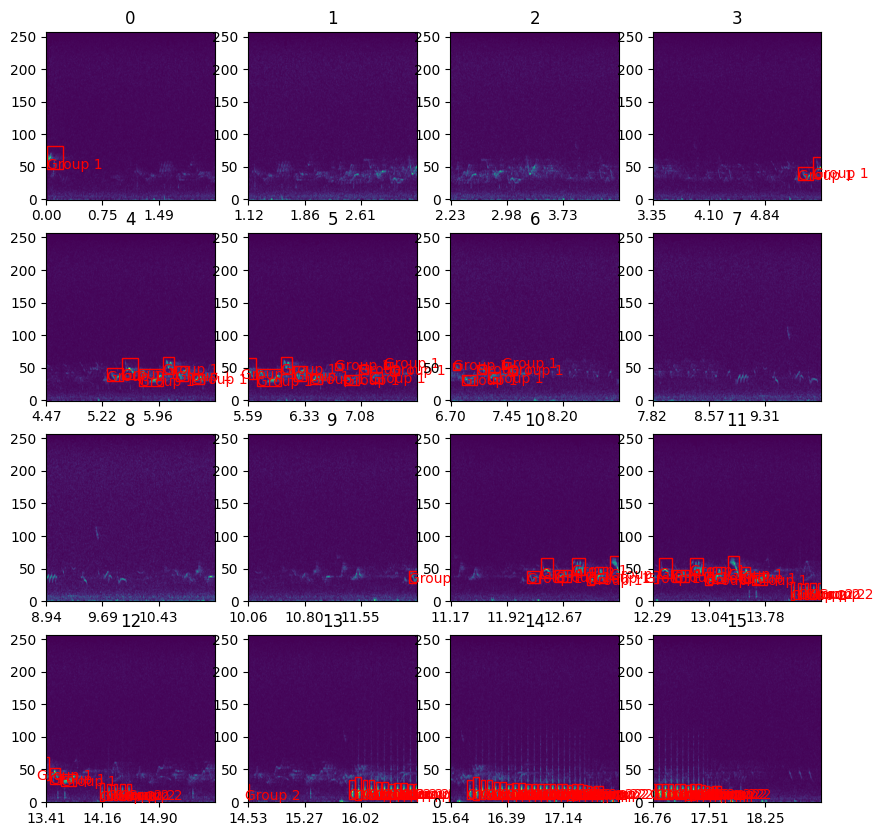

In [8]:
INSPECT_FILE_INDEX = 0

# Get the spectrogram of the audio file
audioSpectrogram, spectrogramFrequencies, timeSpan = GenerateSpectrogram(audioFileNames[INSPECT_FILE_INDEX])
# Get the labels of the audio file
labels = GetLabels(labelFileNames[INSPECT_FILE_INDEX])
# Split the audio file into windows
audioWindows = GetAudioWindows(audioSpectrogram, timeSpan)

# Plot 16 spectrogram slice
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    # Get a window of the spectrogram
    sliceIndex = i
    audioWindow = audioWindows[sliceIndex]
    spectrogramSlice = audioWindow.spectrogramSlice
    ax[i // 4, i % 4].imshow(spectrogramSlice, aspect="auto", origin="lower")
    ax[i // 4, i % 4].set_title("{}".format(i))
    # Set the x-axis to the time scale
    xticks = np.arange(0, spectrogramSlice.shape[1], spectrogramSlice.shape[1] // 3)
    xlabels = [
        "{:.2f}".format(
            audioWindow.startTime + (i / spectrogramSlice.shape[1]) * 
            (audioWindow.endTime - audioWindow.startTime)) for i in xticks]
    ax[i // 4, i % 4].set_xticks(xticks)
    ax[i // 4, i % 4].set_xticklabels(xlabels)
    # Draw all labels
    for label in labels:
        # Find the start and end coordinates of the label
        startX = int(
            (
                label["startTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        endX = int(
            (
                label["endTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        # Find y coordinates by finding the index of first value in spectrogramFrequencies > label frequency
        startY = np.argmax(spectrogramFrequencies > label["startFreq"])
        endY = np.argmax(spectrogramFrequencies > label["endFreq"])
        # Continue if startX > spectrogramSlice.shape[1] or endX < 0
        if startX > spectrogramSlice.shape[1] or endX < 0:
            continue
        # Draw the rectangle
        rect = Rectangle(
            (startX, startY),
            endX - startX,
            endY - startY,
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        ax[i // 4, i % 4].add_patch(rect)
        # Draw the label name
        ax[i // 4, i % 4].text(
            startX,
            startY,
            label["groupName"],
            color="r",
            fontsize=10
        )
plt.show()

## Generate Data Set Utils

In [9]:
class MappedLabel:
    def __init__(
        self,
        label: dict,
        startX: int,
        endX: int,
        startY: int,
        endY: int
    ):
        self.label = label
        self.startX = startX
        self.endX = endX
        self.startY = startY
        self.endY = endY
        
    def GetRect(self):
        """
        Get the (x, y, w, h) rect of the label.
        """
        return np.array([
            self.startX,
            self.startY,
            self.endX - self.startX,
            self.endY - self.startY
        ])
    
    def __repr__(self):
        return "MappedLabel(label={}, startX={}, endX={}, startY={}, endY={})".format(self.label, self.startX, self.endX, self.startY, self.endY)

def GetAvailableLabels(audioWindow: SpectrumWindow, labels: list) -> list:
    """
    Get all available labels for a given audio window
    """
    availableLabels = []
    # Find all labels in the window
    for label in labels:
        # Find the start and end coordinates of the label
        startX = int(
            (
                label["startTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        endX = int(
            (
                label["endTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        # Find y coordinates by finding the index of first value in spectrogramFrequencies > label frequency
        startY = np.argmax(spectrogramFrequencies > label["startFreq"])
        endY = np.argmax(spectrogramFrequencies > label["endFreq"])
        # Continue if startX > spectrogramSlice.shape[1] or endX < 0
        if startX > spectrogramSlice.shape[1] or endX < 0:
            continue
        label = MappedLabel(label, startX, endX, startY, endY)
        availableLabels.append(label)

    return availableLabels

In [10]:
class SelectiveSearcher:
    """
    Searcher to perform selective search.
    """
    def __init__(self):
        self.ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    def Search(self, image: np.ndarray) -> list:
        searchTarget = image
        # Convert searchTarget to float32
        searchTarget = searchTarget.astype(np.float32)
        searchTarget.reshape(
            1,
            audioWindow.spectrogramSlice.shape[0],
            audioWindow.spectrogramSlice.shape[1]
        )
        # Convert gray scale image to RGB
        searchTarget = cv2.cvtColor(searchTarget, cv2.COLOR_GRAY2RGB)
        self.ss.setBaseImage(searchTarget)
        self.ss.switchToSelectiveSearchFast()
        # Search
        rects = self.ss.process()
        
        return rects

In [11]:
def GetIntersection(rect, label: MappedLabel):
    # Get the overlap between the label and the rectangle
    x1, y1, w1, h1 = label.GetRect()
    x2, y2, w2, h2 = rect

    # Get the intersection of the two rectangles
    if x1 < x2:
        x = x2
    else:
        x = x1
    w = min(x1 + w1, x2 + w2) - x

    if y1 < y2:
        y = y2
    else:
        y = y1
    h = min(y1 + h1, y2 + h2) - y

    if w > 0 and h > 0:
        return x, y, w, h
    else:
        return None

In [12]:
class RectLabelPair:
    def __init__(
        self,
        rect,
        label: MappedLabel,
        avgRatio: float,
    ):
        self.rect = rect
        self.label = label
        self.avgRatio = avgRatio
        
        # The offset between current rect and ground truth label
        if label is not None:
            gx = label.startX
            gy = label.startY
            gw = label.endX - label.startX
            gh = label.endY - label.startY
            
            self.offset = np.array([
                gx - rect[0],
                gy - rect[1],
                gw - rect[2],
                gh - rect[3]
            ])
        else:
            self.offset = np.array([0, 0, 0, 0])
    
    def __lt__(self, other):
        return self.avgRatio < other.avgRatio
    
    def __repr__(self):
        return "RectLabelPair({}, {}, {})".format(
            self.rect,
            self.label,
            self.avgRatio
        )

def GetRectLabelPairs(rects, availableLabels) -> list[RectLabelPair]:
    """
    Get all rect-label pairs.
    """
    rectLabelPairs = []
    # Traverse all the rectangles
    for i, rect in enumerate(rects):
        bestFitLabel = None
        bestFitRatiol = 0
        for label in availableLabels:
            intersection = GetIntersection(rect, label)
            if intersection is None:
                continue
            # Calculate the intersection area
            intersectionArea = intersection[2] * intersection[3]
            labelArea = label.GetRect()[2] * label.GetRect()[3]
            rectArea = rect[2] * rect[3]
            # Area ratio
            labelRatio = intersectionArea / labelArea
            rectRatio = intersectionArea / rectArea
            avgRatio = (labelRatio + rectRatio) / 2
            # If the ratio is better than the best ratio, update the best ratio and the best label
            if avgRatio > bestFitRatiol:
                bestFitRatiol = avgRatio
                bestFitLabel = label
        rectLabelPair = RectLabelPair(rect, bestFitLabel, bestFitRatiol)
        rectLabelPairs.append(rectLabelPair)

    rectLabelPairs.sort(reverse=True)
    return rectLabelPairs

### Inspect the Selective Search Results

In [13]:
INSPECT_FILE_INDEX = 0
INSPECT_WINDOW_INDEX = 5
# Load one audio file
# Get the spectrogram of the audio file
audioSpectrogram, spectrogramFrequencies, timeSpan = GenerateSpectrogram(audioFileNames[INSPECT_FILE_INDEX])
# Get the labels of the audio file
labels = GetLabels(labelFileNames[INSPECT_FILE_INDEX])
# Split the audio file into windows
audioWindows = GetAudioWindows(audioSpectrogram, timeSpan)

# Get specified window
audioWindow = audioWindows[INSPECT_WINDOW_INDEX]
availableLabels: list[MappedLabel] = GetAvailableLabels(audioWindow, labels)

# Init searcher
selectiveSearcher = SelectiveSearcher()
rects = selectiveSearcher.Search(audioWindow.spectrogramSlice)
print("Found {} rectangles".format(len(rects)))

Found 86 rectangles


In [14]:
# Get rect-label pairs
rectLabelPairs = GetRectLabelPairs(rects, availableLabels)

# Get all rect-label pairs with avgRatio > 0.7 for positive labels
positivePairs = [pair for pair in rectLabelPairs if pair.avgRatio > POSITIVE_THRESHOLD]
# Get all rect-label pairs with avgRatio < 0.3 for negative labels
negativePairs = [pair for pair in rectLabelPairs if pair.avgRatio < NEGATIVE_THRESHOLD]

len(positivePairs), len(negativePairs)

(10, 31)

In [15]:
# Slice all positive paris and negative pairs
spectrogramSlice = audioWindow.spectrogramSlice
positiveSlice = []
for rectLabelPair in positivePairs:
    rect = rectLabelPair.rect
    x, y, w, h = rect
    positiveSlice.append(spectrogramSlice[y:y + h, x:x + w])
negativeSlice = []
for rectLabelPair in negativePairs:
    rect = rectLabelPair.rect
    x, y, w, h = rect
    negativeSlice.append(spectrogramSlice[y:y + h, x:x + w])
    
len(positiveSlice), len(negativeSlice)

(10, 31)

No intersection
No intersection
Intersection: (0, 33, 33, 31)
No intersection
No intersection
No intersection
No intersection
Intersection: (0, 33, 33, 29)
No intersection
No intersection
No intersection
No intersection
No intersection
No intersection
Intersection: (0, 33, 33, 32)
Intersection: (7, 33, 26, 31)


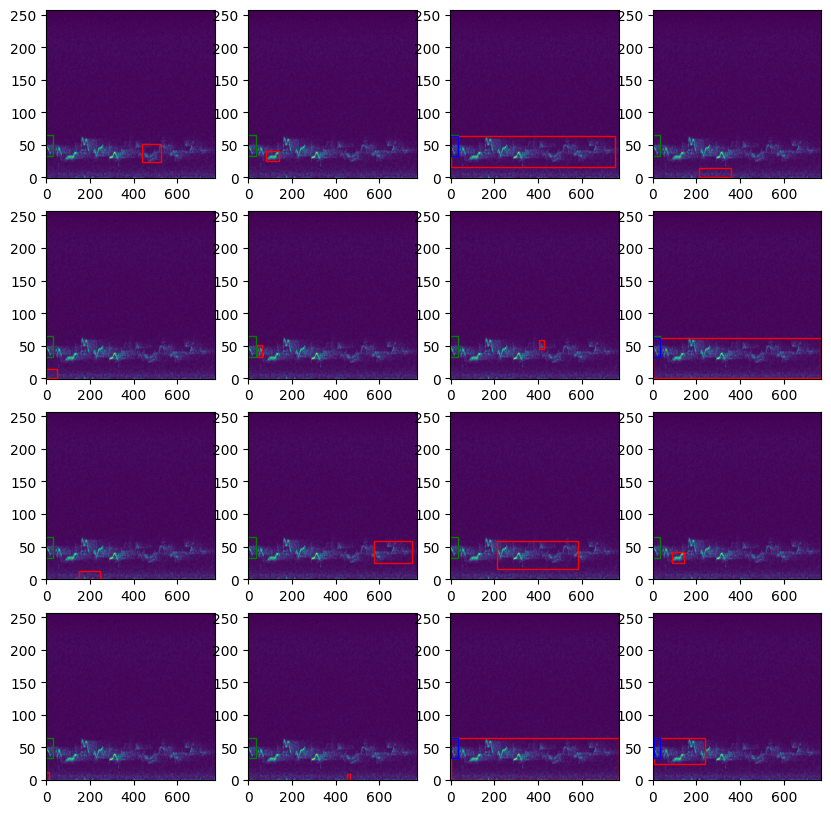

In [16]:
# Display some rectangles and intersecting rectangles
# GREEN is the ground truth
# RED is the selective search result
# BLUE is the intersection
TMP = 1
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax[i // 4, i % 4].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
    rect = rects[TMP + i]
    label = availableLabels[0]
    # Draw the rectangle
    ax[i // 4, i % 4].add_patch(
        Rectangle(
            (rect[0], rect[1]),
            rect[2],
            rect[3],
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
    )
    # Draw the label
    labelRect = label.GetRect()
    ax[i // 4, i % 4].add_patch(
        Rectangle(
            (labelRect[0], labelRect[1]),
            labelRect[2],
            labelRect[3],
            linewidth=1,
            edgecolor="g",
            facecolor="none"
        )
    )

    intersection = GetIntersection(rect, label)
    if intersection is not None:
        print("Intersection: {}".format(intersection))
        ax[i // 4, i % 4].add_patch(
        Rectangle(
            (intersection[0], intersection[1]),
            intersection[2],
            intersection[3],
            linewidth=1,
            edgecolor="b",
            facecolor="none"
        )
    )
    else:
        print("No intersection")

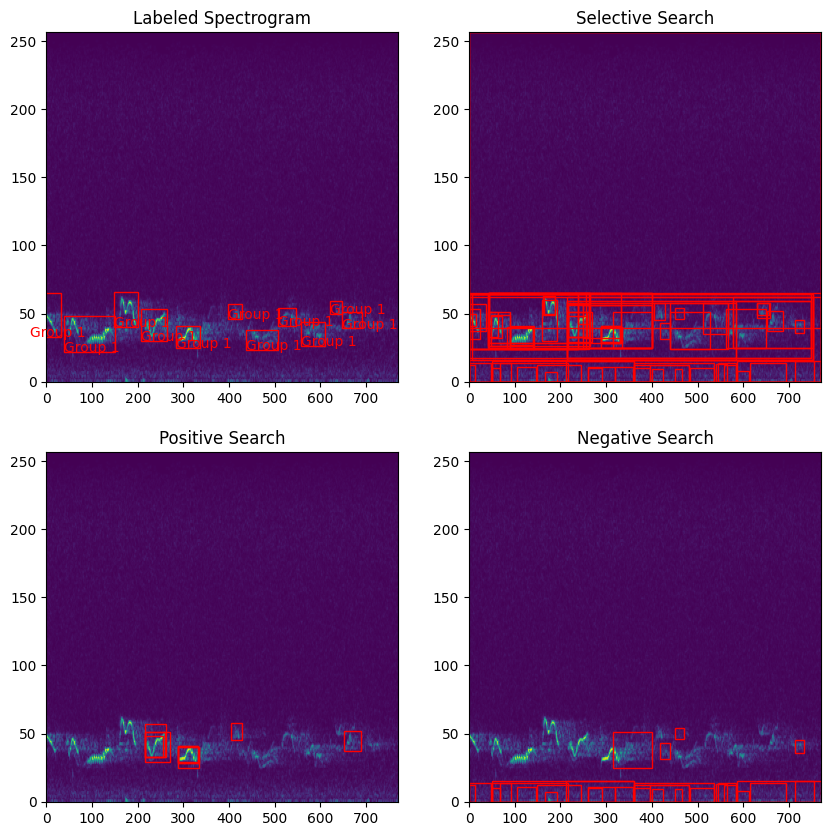

In [17]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# Original spectrogram
ax[0, 0].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[0, 0].set_title("Labeled Spectrogram")
for label in availableLabels:
    rect = Rectangle(
        (label.startX, label.startY),
        label.endX - label.startX,
        label.endY - label.startY,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[0, 0].add_patch(rect)
    ax[0, 0].text(
        label.startX,
        label.startY,
        label.label["groupName"],
        color="r",
        fontsize=10
    )
    
# Selective search result
ax[0, 1].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[0, 1].set_title("Selective Search")
for rect in rects:
    x, y, w, h = rect
    rect = Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[0, 1].add_patch(rect)

# Positive pairs
ax[1, 0].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[1, 0].set_title("Positive Search")
for rectLabelPair in positivePairs:
    rect = rectLabelPair.rect
    label = rectLabelPair.label
    x, y, w, h = rect
    rect = Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[1, 0].add_patch(rect)
# Negative pairs

ax[1, 1].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[1, 1].set_title("Negative Search")
for rectLabelPair in negativePairs:
    rect = rectLabelPair.rect
    label = rectLabelPair.label
    x, y, w, h = rect
    rect = Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[1, 1].add_patch(rect)

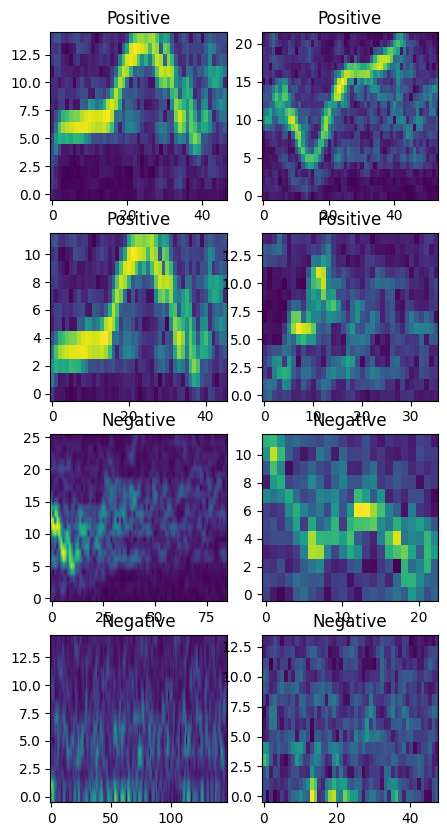

In [18]:
# Display some postive and negative slices
fig, ax = plt.subplots(4, 2, figsize=(5, 10))
for i in range(4):
    # Break if there are no more positive slices
    if i >= len(positiveSlice):
        break
    ax[i // 2, i % 2].imshow(positiveSlice[i], aspect="auto", origin="lower")
    ax[i // 2, i % 2].set_title("Positive")
for i in range(4):
    # Break if there are no more negative slices
    if i >= len(negativeSlice):
        break
    ax[2 + i // 2, i % 2].imshow(negativeSlice[i], aspect="auto", origin="lower")
    ax[2 + i // 2, i % 2].set_title("Negative")

# Generate Data Set

## Preprocessing

1. Read in the audio data
2. Generate the spectrogram
3. Read labels
4. Slice the spectrogram into overlapping windows

## Selective Search

1. Selective search the spectrogram to get the regions of interest
2. Calculate the overlapping ratio between each region of interest and the ground truth
3. Sort and select postive and negative regions of interest


In [19]:
# Positive and negative pairs
positivePairs: list[RectLabelPair] = []
negativePairs: list[RectLabelPair] = []
positiveSlices: list[np.ndarray] = []
negativeSlices: list[np.ndarray] = []

# Traverse all files
for i in range(len(audioFileNames)):
    audioFileName = audioFileNames[i]
    labelFileName = labelFileNames[i]
    print("Processing {}".format(audioFileName))
    # Get the spectrogram of the audio file
    audioSpectrogram, spectrogramFrequencies, spectrogramTimes = GenerateSpectrogram(audioFileName)
    # Get the labels of the audio file
    labels = GetLabels(labelFileName)
    # Split the audio file into windows
    audioWindows = GetAudioWindows(audioSpectrogram, timeSpan)
    
    # Init searcher
    selectiveSearcher = SelectiveSearcher()
    
    # Travers all windows
    for i, audioWindow in enumerate(audioWindows):
        # Get all available labels
        availableLabels: list[MappedLabel] = GetAvailableLabels(audioWindow, labels)
        # Selective search
        rects = selectiveSearcher.Search(audioWindow.spectrogramSlice)
        # Calculate the overlap between the selective search result and the available labels
        rectLabelPairs = GetRectLabelPairs(rects, availableLabels)
        # Get all rect-label pairs with avgRatio > 0.7 for positive labels
        _positivePairs = [pair for pair in rectLabelPairs if pair.avgRatio > POSITIVE_THRESHOLD]
        # Get all rect-label pairs with avgRatio < 0.3 for negative labels
        _negativePairs = [pair for pair in rectLabelPairs if pair.avgRatio < NEGATIVE_THRESHOLD]
        # Extend the positive and negative pairs
        positivePairs.extend(_positivePairs)
        negativePairs.extend(_negativePairs)
        
        # Slice the positive and negative pairs
        spectrogramSlice = audioWindow.spectrogramSlice
        positiveSlice = []
        for rectLabelPair in _positivePairs:
            rect = rectLabelPair.rect
            x, y, w, h = rect
            positiveSlice.append(spectrogramSlice[y:y + h, x:x + w])
        negativeSlice = []
        for rectLabelPair in _negativePairs:
            rect = rectLabelPair.rect
            x, y, w, h = rect
            negativeSlice.append(spectrogramSlice[y:y + h, x:x + w])
        
        # Extend the positive and negative slices
        positiveSlices.extend(positiveSlice)
        negativeSlices.extend(negativeSlice)

print("Positive pairs: {}".format(len(positivePairs)))
print("Negative pairs: {}".format(len(negativePairs)))

Processing sample_2_chan0.wav
Positive pairs: 1091
Negative pairs: 3055


In [20]:
# Randomly select positive and negative pairs to make sure the number of positive and negative pairs is the same

# if len(positivePairs) > len(negativePairs):
#     positivePairs = random.sample(positivePairs, len(negativePairs))
# elif len(positivePairs) < len(negativePairs):
#     negativePairs = random.sample(negativePairs, len(positivePairs))

# print("Positive pairs: {}".format(len(positivePairs)))
# print("Negative pairs: {}".format(len(negativePairs)))

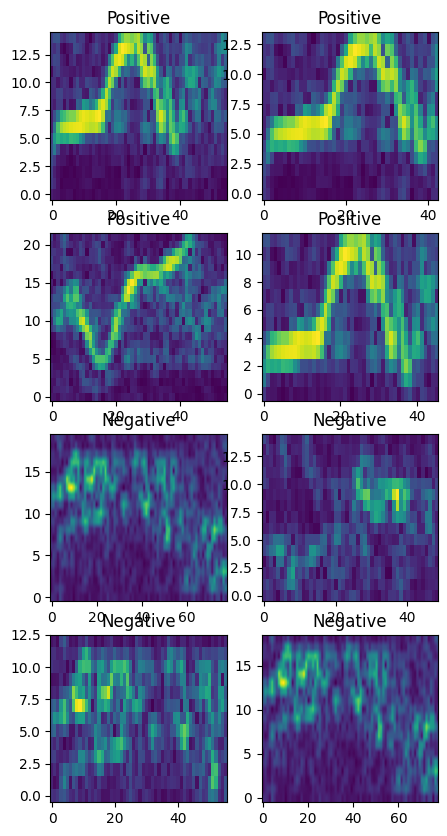

In [21]:
# Display some postive and negative slices
fig, ax = plt.subplots(4, 2, figsize=(5, 10))
for i in range(4):
    # Break if there are no more positive slices
    if i >= len(positiveSlices):
        break
    ax[i // 2, i % 2].imshow(positiveSlices[i], aspect="auto", origin="lower")
    ax[i // 2, i % 2].set_title("Positive")
for i in range(4):
    # Break if there are no more negative slices
    if i >= len(negativeSlices):
        break
    ax[2 + i // 2, i % 2].imshow(negativeSlices[i], aspect="auto", origin="lower")
    ax[2 + i // 2, i % 2].set_title("Negative")

# Save Data Set

In [22]:
TARGET_PATH = "output"
TARGET_DIR = "dataSet"
outputDirPath = os.path.join(TARGET_PATH, TARGET_DIR)
# Create the output directory if it does not exist
if not os.path.exists(outputDirPath):
    os.makedirs(outputDirPath)

In [23]:
def GetMetadata(pair: RectLabelPair) -> dict:
    # Get the react from the pair
    rect = pair.rect
    # Convert the y coordinate to frequency
    startFreq = spectrogramFrequencies[rect[1]]
    endFreq = spectrogramFrequencies[min(rect[1] + rect[3], len(spectrogramFrequencies) - 1)]
    # Get the time span from the pair
    timeSpan = rect[2] / audioSpectrogram.shape[1] * spectrogramTimes
    # Contruct metadata
    metadata = {
        "startFreq": startFreq,
        "endFreq": endFreq,
        "timeSpan": timeSpan,
    }
    
    return metadata

In [24]:
labels = dict()
metadatas = dict()

# Create the spectrogram directory if it does not exist
spectrogramDir = os.path.join(outputDirPath, "spectrogram")
if not os.path.exists(spectrogramDir):
    os.makedirs(spectrogramDir)
    
for i, (slice, pair) in enumerate(zip(positiveSlices, positivePairs)):
    # Save the slice
    sliceFileName = "positive_{}.png".format(i)
    sliceFilePath = os.path.join(spectrogramDir, sliceFileName)
    plt.imsave(sliceFilePath, slice)
    # Get the metadata
    metadatas[sliceFileName] = GetMetadata(pair)
    # Construct the label
    labels[sliceFileName] = {
        "isPositive": True,
        "offset": {
            "x": int(pair.offset[0]),
            "y": int(pair.offset[1]),
            "w": int(pair.offset[2]),
            "h": int(pair.offset[3]),
        }
    }
    
for i, (slice, pair) in enumerate(zip(negativeSlices, negativePairs)):
    # Save the slice
    sliceFileName = "negative_{}.png".format(i)
    sliceFilePath = os.path.join(spectrogramDir, sliceFileName)
    plt.imsave(sliceFilePath, slice)
    # Get the metadata
    metadatas[sliceFileName] = GetMetadata(pair)
    # Construct the label
    labels[sliceFileName] = {
        "isPositive": False,
        "offset": {
            "x": int(pair.offset[0]),
            "y": int(pair.offset[1]),
            "w": int(pair.offset[2]),
            "h": int(pair.offset[3]),
        }
    }

# Write the metadata to a json file
json.dump(
    metadatas,
    open(os.path.join(outputDirPath, "metadata.json"), "w"),
    indent=4
)
# Write the positive labels to a json file
json.dump(
    labels,
    open(os.path.join(outputDirPath, "labels.json"),"w"),
    indent=4
)